Mounted at /content/drive
Gráfico salvo em: /content/drive/My Drive/graficos/compatibility_matrix.png
Gráfico salvo em: /content/drive/My Drive/graficos/factor_loadings.png
Gráfico salvo em: /content/drive/My Drive/graficos/extroversao_bootstrap_histogram.png
Gráfico salvo em: /content/drive/My Drive/graficos/histograma_narcisismo.png
Gráfico salvo em: /content/drive/My Drive/graficos/pairplot_extroversao_satisfacao.png
Gráfico salvo em: /content/drive/My Drive/graficos/pairplot_amabilidade_satisfacao.png
Gráfico salvo em: /content/drive/My Drive/graficos/pairplot_neuroticismo_sociosexualidade.png
Gráfico salvo em: /content/drive/My Drive/graficos/pairplot_abertura_desejo.png
Gráfico salvo em: /content/drive/My Drive/graficos/facetgrid_psicopatia.png
Gráfico salvo em: /content/drive/My Drive/graficos/facetgrid_maquiavelismo.png
Gráfico salvo em: /content/drive/My Drive/graficos/facetgrid_extroversao.png
Gráfico salvo em: /content/drive/My Drive/graficos/violino_impulso_proprio.png
Gráf

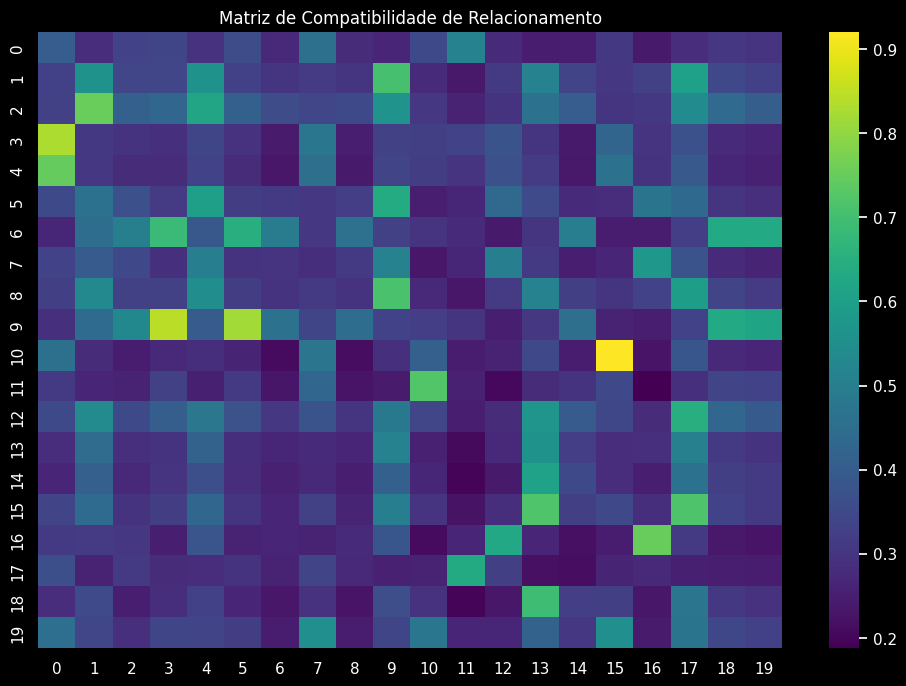

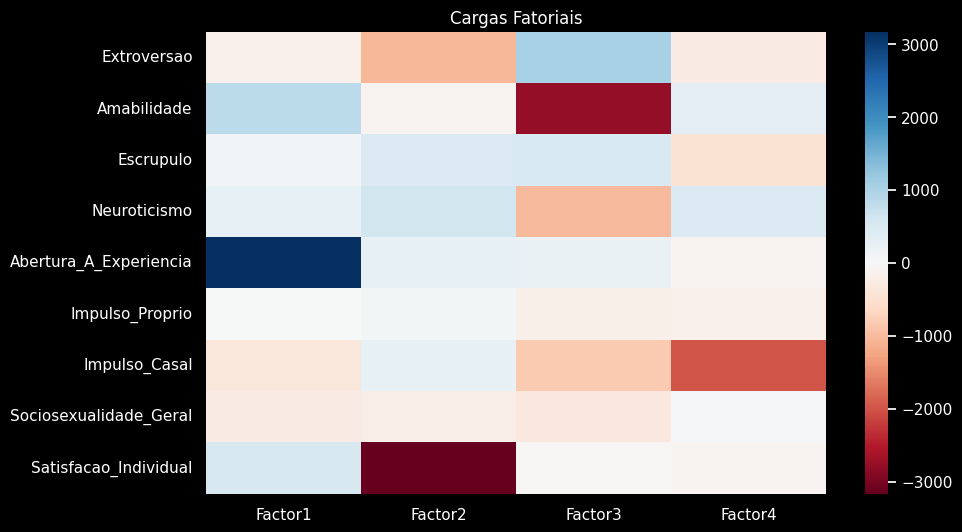

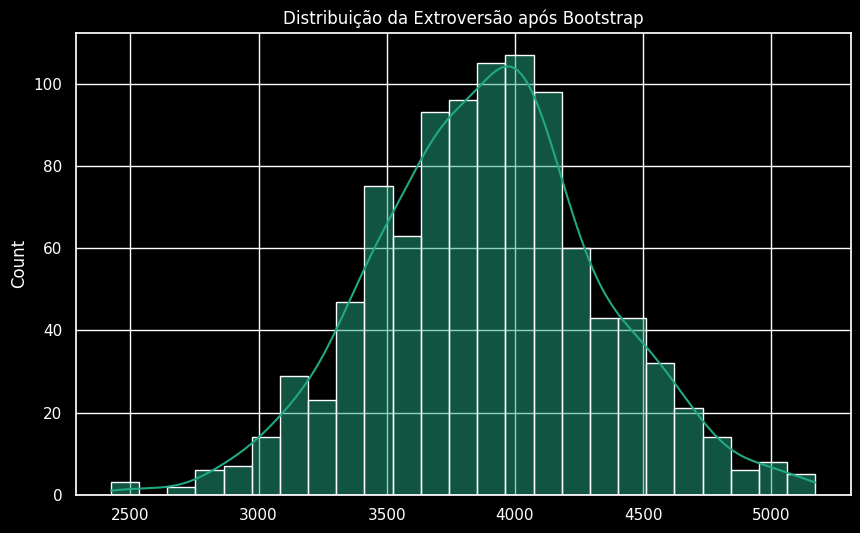

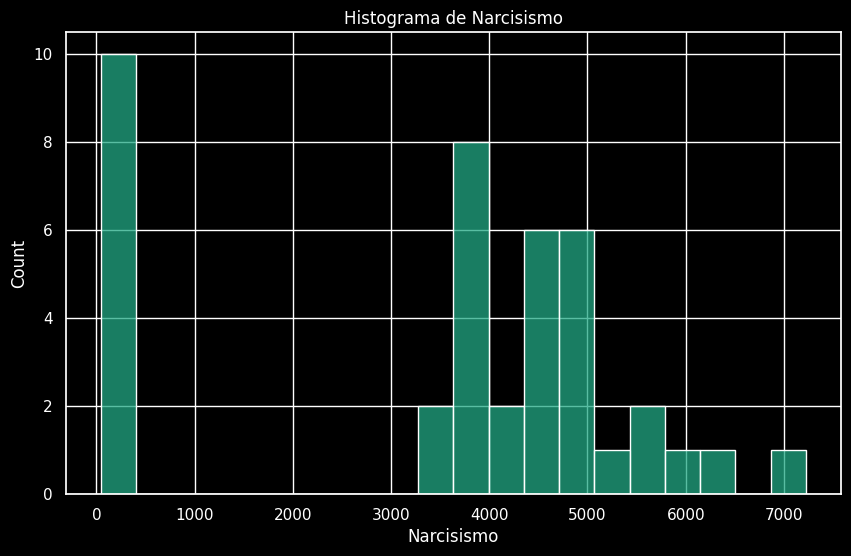

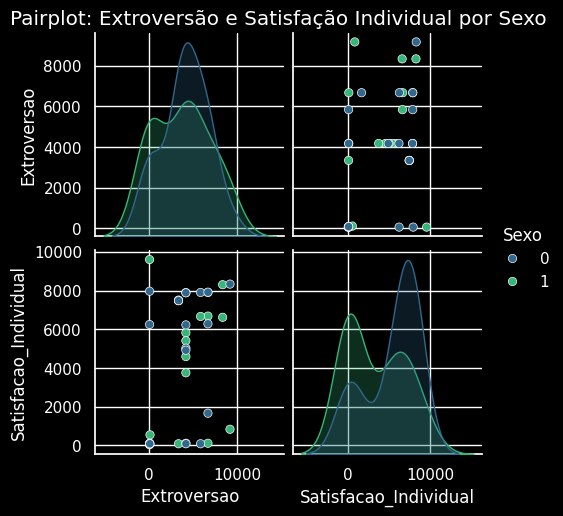

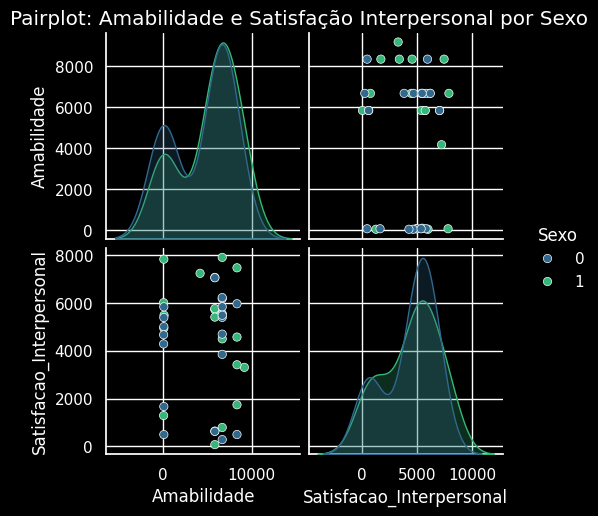

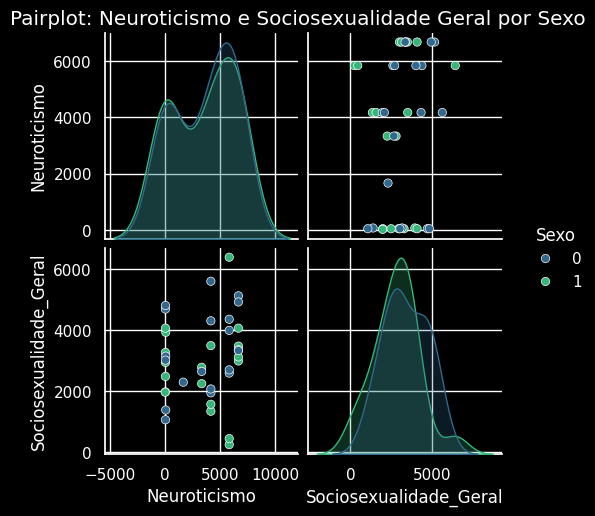

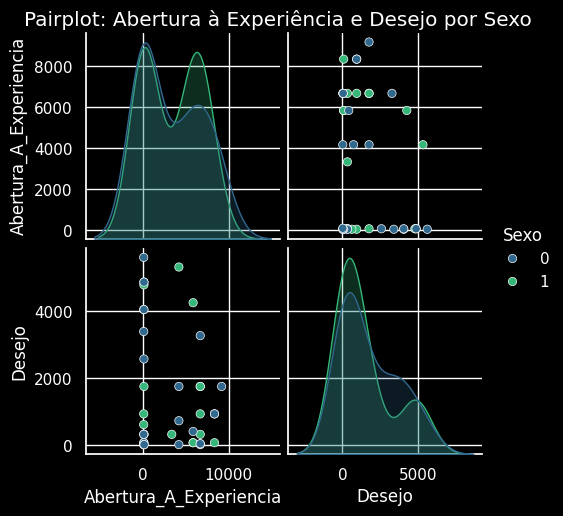

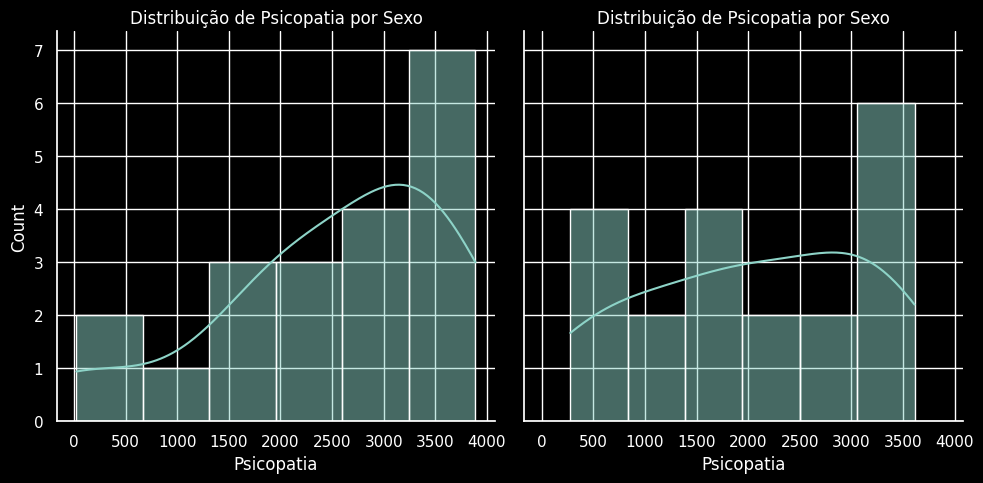

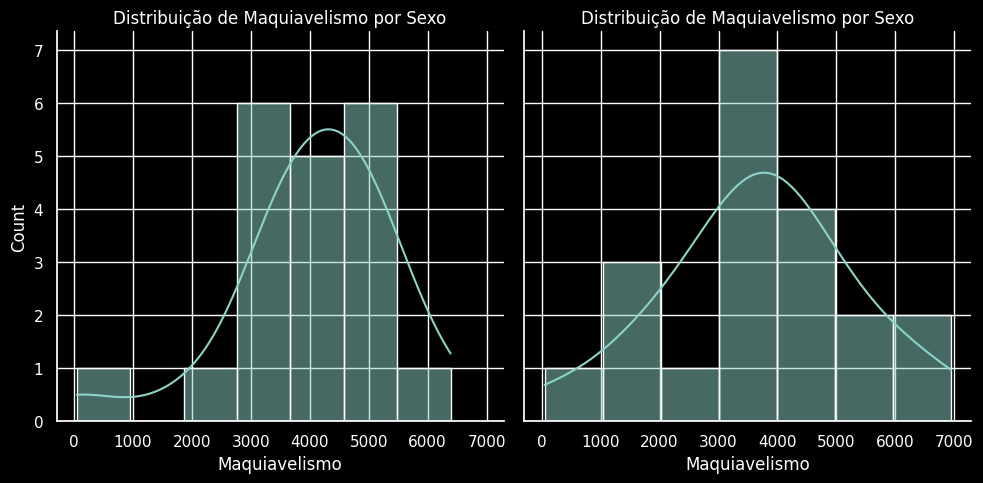

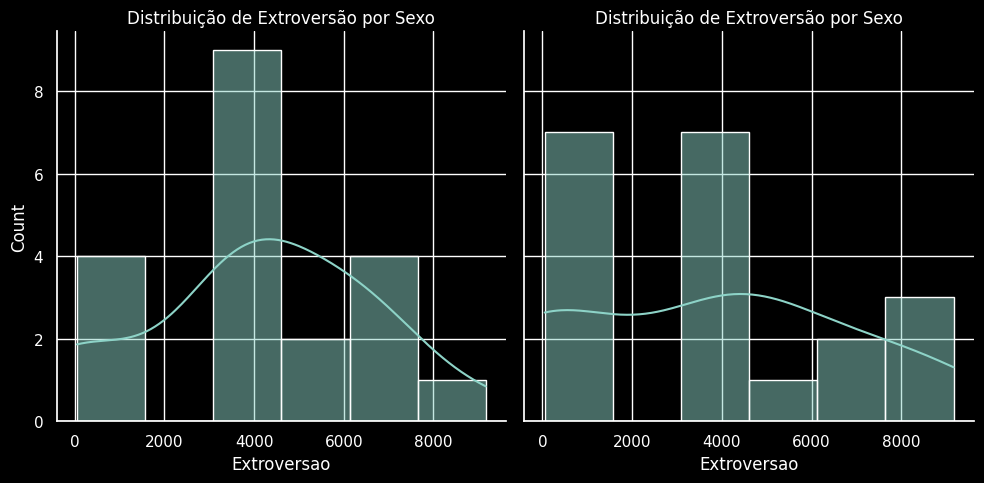

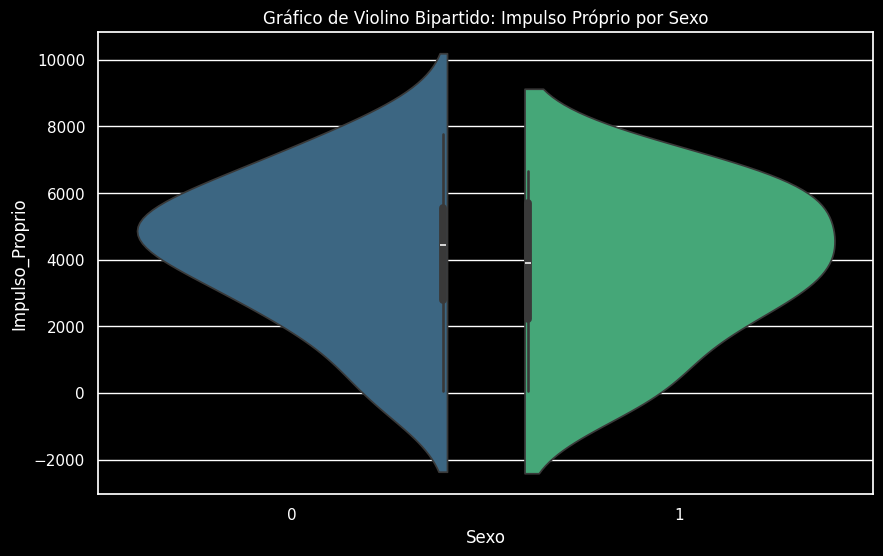

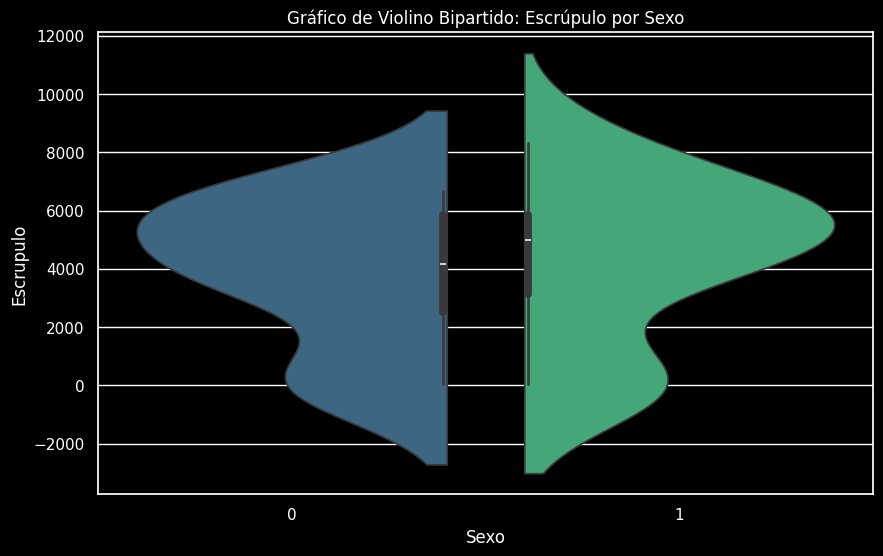

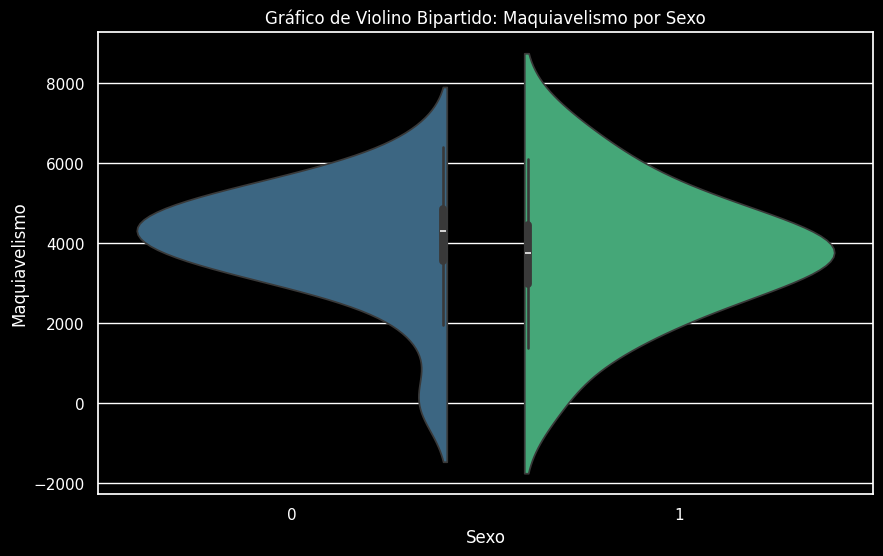

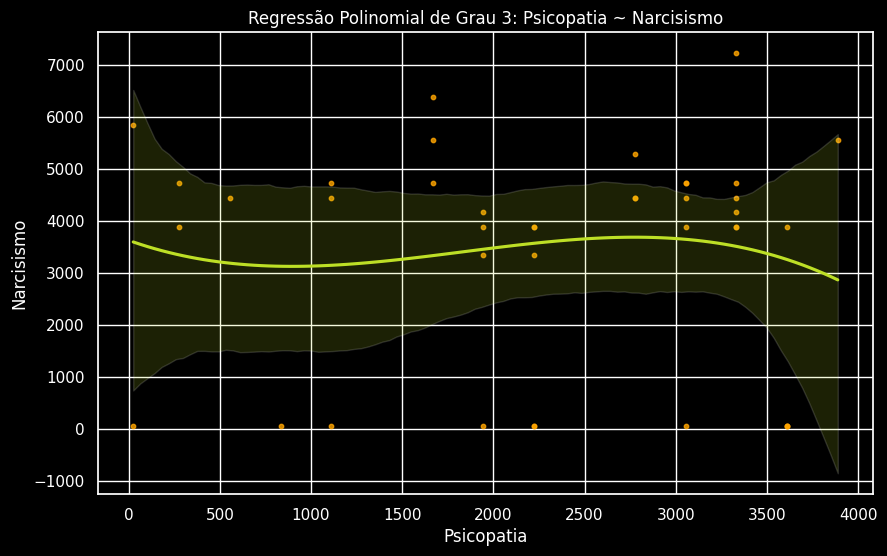

In [3]:
# Importando as bibliotecas necessárias
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.utils import resample
from scipy.optimize import linear_sum_assignment
from scipy import stats
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import patsy
from google.colab import auth
from google.auth import default
import gspread
from google.colab import drive

# Montando o Google Drive para salvar os gráficos e o sumário
drive.mount('/content/drive', force_remount=True)

# Autenticação no Google Drive e Google Sheets
def authenticate_google_drive():
    auth.authenticate_user()
    creds, _ = default()
    gspread_client = gspread.authorize(creds)
    return gspread_client

# Carregar os dados diretamente do Google Sheets
def load_data_from_sheets(sheet_url):
    gspread_client = authenticate_google_drive()
    sheet = gspread_client.open_by_url(sheet_url).sheet1
    data = pd.DataFrame(sheet.get_all_records())
    return data

# Pré-processamento dos dados
def load_and_preprocess(data):
    personality_cols = ['Extroversao', 'Amabilidade', 'Escrupulo', 'Neuroticismo', 'Abertura_A_Experiencia']
    dating_cols = ['Impulso_Proprio', 'Impulso_Casal', 'Sociosexualidade_Geral', 'Satisfacao_Individual']
    X = data[personality_cols + dating_cols].apply(pd.to_numeric, errors='coerce')
    return X, pd.to_numeric(data['Sexo'], errors='coerce')

# Determinar o número ideal de fatores
def determine_factors(X):
    ev, _ = np.linalg.eig(np.corrcoef(X, rowvar=False))
    return sum(ev > 1)

# Extração e rotação dos fatores
def extract_and_rotate(X, n_factors):
    fa = FactorAnalysis(n_components=n_factors)
    fa.fit(X)
    loadings = pd.DataFrame(
        fa.components_.T,
        columns=[f'Factor{i+1}' for i in range(n_factors)],
        index=X.columns
    )
    return loadings

# Calcular a compatibilidade entre homens e mulheres
def calculate_compatibility(X_female, X_male):
    scaler = StandardScaler()
    X_female_scaled = scaler.fit_transform(X_female)
    X_male_scaled = scaler.transform(X_male)

    factor = FactorAnalysis(n_components=3)
    factor.fit(np.vstack([X_female_scaled, X_male_scaled]))

    female_scores = factor.transform(X_female_scaled)
    male_scores = factor.transform(X_male_scaled)

    compatibility = np.zeros((len(X_female), len(X_male)))
    for i in range(len(female_scores)):
        for j in range(len(male_scores)):
            compatibility[i,j] = 1 / (1 + np.sqrt(np.sum((female_scores[i] - male_scores[j])**2)))

    return pd.DataFrame(compatibility)

# Otimizar a correspondência entre homens e mulheres
def optimal_matching(compatibility):
    row_ind, col_ind = linear_sum_assignment(-compatibility.values)
    matches = pd.DataFrame({
        'Female_Index': row_ind,
        'Male_Index': col_ind,
        'Compatibility_Score': compatibility.values[row_ind, col_ind]
    })
    return matches.sort_values('Compatibility_Score', ascending=False)

# Função para realizar o bootstrap
def bootstrap(data, n_iterations=1000):
    bootstrap_results = [resample(data, n_samples=len(data), replace=True) for _ in range(n_iterations)]
    return bootstrap_results

# Neighborhood Components Analysis (NCA)
def neighborhood_components_analysis(data, labels):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    nca = NeighborhoodComponentsAnalysis(random_state=42)
    nca_data = nca.fit_transform(data_scaled, labels)

    return pd.DataFrame(nca_data, columns=[f'NCA_{i+1}' for i in range(nca_data.shape[1])])

# Sumário estatístico e análise
def sumario_estatistico_analise(df):
    if df is None or df.empty:
        print("DataFrame vazio ou inválido.")
        return

    with open('/content/drive/My Drive/graficos/sumario.txt', 'w') as f:
        f.write('Sumário Estatístico Detalhado:\n')

        variaveis = ['Sociosexualidade_Geral', 'Atitude', 'Desejo', 'Promocao', 'Satisfacao_Individual',
                     'Satisfacao_Interpersonal', 'Extroversao', 'Amabilidade', 'Neuroticismo',
                     'Abertura_A_Experiencia', 'Narcisismo', 'Psicopatia', 'Impulso_Proprio',
                     'Impulso_Casal', 'Escrupulo', 'Maquiavelismo']

        correlacoes = {}
        for var1 in variaveis:
            for var2 in variaveis:
                if var1 != var2:
                    correlacao, p_valor_corr = stats.pearsonr(df[var1].dropna(), df[var2].dropna())
                    correlacoes[f'{var1} ~ {var2}'] = (correlacao, p_valor_corr)
                    f.write(f'Correlação entre {var1} e {var2}: r={correlacao:.4f}, p={p_valor_corr:.4f}\n')

        formula = ' + '.join(variaveis) + ' ~ Sexo + Idade'
        try:
            manova = MANOVA.from_formula(formula, data=df)
            resultados_manova = manova.mv_test()

            try:
                pillai_trace = resultados_manova.results['Sexo']['stat'].iloc[0, 0]
                f_value = resultados_manova.results['Sexo']['stat'].iloc[0, 1]
                df1 = resultados_manova.results['Sexo']['stat'].iloc[0, 2]
                df2 = resultados_manova.results['Sexo']['stat'].iloc[0, 3]
                p_value = resultados_manova.results['Sexo']['stat'].iloc[0, 4]
                f.write(f"\nResultados da MANCOVA (Pillai's trace):\nPillai's trace = {pillai_trace:.4f}, F({df1}, {df2}) = {f_value:.4f}, p = {p_value:.4f}\n")
            except KeyError:
                f.write("\nErro: 'Pillai's trace' ou estatísticas relacionadas não encontradas.\n")

        except np.linalg.LinAlgError:
            f.write("\nErro na MANCOVA: Matriz singular. Verifique os dados para colinearidade ou variáveis constantes.\n")

        f.write("\nResultados do Post-Hoc (Tukey HSD):\n")
        post_hoc_tests = {}
        for var in ['Impulso_Proprio', 'Impulso_Casal', 'Escrupulo', 'Maquiavelismo']:
            df_dropna = df.dropna(subset=[var])
            post_hoc = pairwise_tukeyhsd(df_dropna[var], df_dropna['Sexo'], alpha=0.05)
            post_hoc_tests[var] = post_hoc.summary()
            f.write(f"Post-Hoc para {var}:\n{post_hoc_tests[var]}\n")

    return resultados_manova, post_hoc_tests, correlacoes

# Salvar gráficos no Google Drive
def save_plot(fig, filename):
    drive_path = '/content/drive/My Drive/graficos/'
    if not os.path.exists(drive_path):
        os.makedirs(drive_path)

    path = os.path.join(drive_path, filename)
    fig.savefig(path)
    print(f"Gráfico salvo em: {path}")

# Visualizar resultados e gerar gráficos
def visualize_results(compatibility, matches, loadings, bootstrap_samples, df):
    sns.set(style="whitegrid")
    plt.style.use("dark_background")
    cmap = sns.color_palette("viridis", as_cmap=True)

    # Matriz de compatibilidade
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(compatibility, cmap=cmap, ax=ax)
    ax.set_title('Matriz de Compatibilidade de Relacionamento')
    save_plot(fig, 'compatibility_matrix.png')

    # Cargas fatoriais
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(loadings, cmap='RdBu', center=0, ax=ax)
    ax.set_title('Cargas Fatoriais')
    save_plot(fig, 'factor_loadings.png')

    # Distribuição da Extroversão após Bootstrap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot([sample['Extroversao'].mean() for sample in bootstrap_samples], ax=ax, kde=True, color=cmap(0.6))
    ax.set_title('Distribuição da Extroversão após Bootstrap')
    save_plot(fig, 'extroversao_bootstrap_histogram.png')

    # Histograma de Narcisismo
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(df['Narcisismo'], kde=False, color=cmap(0.6), bins=20)
    ax.set_title('Histograma de Narcisismo')
    save_plot(fig, 'histograma_narcisismo.png')

    # Pairplot com Extroversão, Satisfação Individual e Sexo
    fig = sns.pairplot(df[['Extroversao', 'Satisfacao_Individual', 'Sexo']], hue='Sexo', palette="viridis")
    fig.fig.suptitle('Pairplot: Extroversão e Satisfação Individual por Sexo', y=1.02)
    save_plot(fig.fig, 'pairplot_extroversao_satisfacao.png')

    # Pairplot: Relação entre Amabilidade e Satisfação Interpersonal
    fig = sns.pairplot(df[['Amabilidade', 'Satisfacao_Interpersonal', 'Sexo']], hue='Sexo', palette="viridis")
    fig.fig.suptitle('Pairplot: Amabilidade e Satisfação Interpersonal por Sexo', y=1.02)
    save_plot(fig.fig, 'pairplot_amabilidade_satisfacao.png')

    # Pairplot: Relação entre Neuroticismo e Sociosexualidade Geral
    fig = sns.pairplot(df[['Neuroticismo', 'Sociosexualidade_Geral', 'Sexo']], hue='Sexo', palette="viridis")
    fig.fig.suptitle('Pairplot: Neuroticismo e Sociosexualidade Geral por Sexo', y=1.02)
    save_plot(fig.fig, 'pairplot_neuroticismo_sociosexualidade.png')

    # Pairplot: Relação entre Abertura à Experiência e Desejo
    fig = sns.pairplot(df[['Abertura_A_Experiencia', 'Desejo', 'Sexo']], hue='Sexo', palette="viridis")
    fig.fig.suptitle('Pairplot: Abertura à Experiência e Desejo por Sexo', y=1.02)
    save_plot(fig.fig, 'pairplot_abertura_desejo.png')

    # FacetGrid: Psicopatia e Impulso Próprio com uma grade por Sexo
    g = sns.FacetGrid(df.dropna(), col="Sexo", palette="viridis", height=5)
    g.map(sns.histplot, 'Psicopatia', kde=True)
    g.set_titles("Distribuição de Psicopatia por Sexo")
    save_plot(g.fig, 'facetgrid_psicopatia.png')

    # FacetGrid: Maquiavelismo com uma grade por Sexo
    g = sns.FacetGrid(df.dropna(), col="Sexo", palette="viridis", height=5)
    g.map(sns.histplot, 'Maquiavelismo', kde=True)
    g.set_titles("Distribuição de Maquiavelismo por Sexo")
    save_plot(g.fig, 'facetgrid_maquiavelismo.png')

    # FacetGrid: Extroversão com uma grade por Sexo
    g = sns.FacetGrid(df.dropna(), col="Sexo", palette="viridis", height=5)
    g.map(sns.histplot, 'Extroversao', kde=True)
    g.set_titles("Distribuição de Extroversão por Sexo")
    save_plot(g.fig, 'facetgrid_extroversao.png')

    # Gráfico de violino bipartido: Impulso Próprio por Sexo
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(x='Sexo', y='Impulso_Proprio', data=df, split=True, hue='Sexo', palette="viridis", legend=False)
    ax.set_title('Gráfico de Violino Bipartido: Impulso Próprio por Sexo')
    save_plot(fig, 'violino_impulso_proprio.png')

    # Gráfico de violino bipartido: Escrúpulo por Sexo
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(x='Sexo', y='Escrupulo', data=df, split=True, hue='Sexo', palette="viridis", legend=False)
    ax.set_title('Gráfico de Violino Bipartido: Escrúpulo por Sexo')
    save_plot(fig, 'violino_escrupulo.png')

    # Gráfico de violino bipartido: Maquiavelismo por Sexo
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(x='Sexo', y='Maquiavelismo', data=df, split=True, hue='Sexo', palette="viridis", legend=False)
    ax.set_title('Gráfico de Violino Bipartido: Maquiavelismo por Sexo')
    save_plot(fig, 'violino_maquiavelismo.png')

    # Regressão polinomial de grau 3: Psicopatia ~ Narcisismo
    df = df.dropna(subset=['Psicopatia', 'Narcisismo'])
    df['Psicopatia'] = pd.to_numeric(df['Psicopatia'], errors='coerce')
    df['Narcisismo'] = pd.to_numeric(df['Narcisismo'], errors='coerce')
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.regplot(x='Psicopatia', y='Narcisismo', data=df, order=3, scatter_kws={'s': 10, 'color': 'orange'}, line_kws={"color": cmap(0.9)})
    ax.set_title('Regressão Polinomial de Grau 3: Psicopatia ~ Narcisismo')
    save_plot(fig, 'regressao_polinomial_psicopatia_narcisismo.png')

# Função principal
def main():
    # URL da planilha do Google Sheets
    sheet_url = 'https://docs.google.com/spreadsheets/d/1CNNFeecI-prP06vzS3xnQ8jj3ZY8wABxL4R8BsG35_s/edit?gid=1173412179#gid=1173412179'

    # Carregar e pré-processar os dados
    data = load_data_from_sheets(sheet_url)
    X, sex = load_and_preprocess(data)

    # Determinar o número de fatores e realizar a extração
    n_factors = determine_factors(X)
    loadings = extract_and_rotate(X, n_factors)

    # Separar dados femininos e masculinos
    X_female = X[sex == 0].dropna()
    X_male = X[sex == 1].dropna()

    # Calcular compatibilidade
    compatibility = calculate_compatibility(X_female, X_male)

    # Otimizar correspondência entre homens e mulheres
    matches = optimal_matching(compatibility)

    # Realizar bootstrap
    bootstrap_samples = bootstrap(X)

    # Visualizar resultados
    visualize_results(compatibility, matches, loadings, bootstrap_samples, data)

    # Sumário estatístico detalhado
    resultados_manova, post_hoc_tests, correlacoes = sumario_estatistico_analise(data)

if __name__ == "__main__":
    main()